# Assignment 4: A GRU-pair model for SNLI with attention

In this assignment we'll build and train an attention-based model for SNLI based on the word-by-word attention with matching layer designed from [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf). 


As in Lab5  we'll focus on  __Natural Language Inference__ (NLI) task. Recall that NLI consists in determining whether a natural language _hypothesis_ can justifiably be inferred from a natural language _premise_. Thus given a pair of  premise  and  hypothesis texts, the task is to classify them into three categories: _entailment_, _contradiction_, and _neutral_. The table below shows a few examples of premise/hypothesis along with the annotated labels (examples taken from [here](https://nlp.stanford.edu/pubs/snli_paper.pdf)).

The dataset we will use in this lab can be downloaded from [here](https://nlp.stanford.edu/projects/snli/) and it is a corpus comprised by The Stanford Natural Language Processing Group. Actually we are using a subset of the whole dataset. This is the same subset used in Lab5 so you can compare the results. 


| Premise                                                               | Category      | Hypothesis                                                         |
|:--------------------------------------------------------------------|:---------------|:--------------------------------------------------------------------|
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping                                                |
| An older and younger man smiling.                                  | neutral       | Two men are smiling and laughing at the cats playing on the floor. |
| A black race car starts up in front of a crowd of people.          | contradiction | A man is driving down a lonely road.                               |
| A soccer game with multiple males playing.                         | entailment    | Some men are playing a sport.                                     |
| A smiling costumed woman is holding an umbrella.                   | neutral       | A happy woman in a fairy costume holds an umbrella.                |

----

## Attention Model
As stated above, the model will incorporate the basic __word-by-word attention__ + __matching layer__ design from [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf), but it will use __GRUs__ instead of LSTMs, and it will use [Luong et al.](http://www.aclweb.org/anthology/D15-1166)'s 'general' bilinear attention scoring function. See below for the implementation details.

>>> ![](https://drive.google.com/uc?id=11Y9qwCUaTKV-CRxtbXindwxKNnVnn15a)


The paper proposes to use three LSTMs (GRU in our case) to 1) encode the steps in the premise ($H^{s}$),  2) encode the steps in hypothesis (e.g $h_{k}^{t}$) and 3) encode the matching steps ($h_{k}^{m}$). Please go to  [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf) to understand the details of the architecture and the attention model. 



__Note__: Do not start this assignment at the last minute, since the model you build may take several hours to train.

## Setup

You will need first to mount your Google Drive  folder and give access to the Notebook. Please run the following cell and follow the instructions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/LAP/Subjects/DL/assignments

/content/drive/MyDrive/LAP/Subjects/DL/assignments


In a similar way as in previous labs, we'll first load the data and inspect it. You should have you data in your drive under ```dl4nlp_labs/data/snli``` (the data is the same the one that you can downloaded from [here](https://nlp.stanford.edu/projects/snli/) , but we get rid off stuff we do not need this lab).

You we'll need to mount your Drive folder first to access the data. This will require one-step authentication. Please when you run the cell below follow the instructions. Once you mount everything, make sure ```snli_home = 'drive/My Drive/Colab Notebooks/dl4nlp_labs/data/snli/``` is correct path for your data.

The cells below upload the training, development and test files:

-  ```snli_1.0_train.jsonl.bz2```
- ```snli_1.0_dev.jsonl.bz2```
-  ```snli_1.0_test.jsonl.bz2```


In [3]:
snli_home = '../data/snli'

import bz2
import re
import random
import json

LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

def load_snli_data(path):
    data = []
    with bz2.open(path) as f:
        for line in f:
            line = line.decode('utf-8')
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
        random.seed(1)
        random.shuffle(data)
    return data
     
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl.bz2')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl.bz2')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl.bz2')

Next, we'll convert the data to index vectors in the same way that we've done for in-class exercises with RNN-based sentiment models. A few notes:

- We use a sequence length of only 10, which is short enough that we're truncating a large fraction of sentences.
- Tokenization is easy here because we're relying on the output of a parser (which does tokenization as part of parsing), just as with the SST corpus that we've been using until now. Note that we use the 'sentence1_binary_parse' field of each example rather than the human-readable 'sentence1'.
- We're using a moderately large vocabulary of about 36k words.

In [4]:
SEQ_LEN = 10

import collections
import numpy as np

def sentences_to_padded_index_sequences(datasets):
    '''Annotates datasets with feature vectors.'''
    
    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    
    # Extract vocabulary
    def tokenize(string):
        string = re.sub(r'\(|\)', '', string)
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['sentence1_binary_parse']))
        word_counter.update(tokenize(example['sentence2_binary_parse']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            for sentence in ['sentence1_binary_parse', 'sentence2_binary_parse']:
                example[sentence + '_index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

                token_sequence = tokenize(example[sentence])
                padding = SEQ_LEN - len(token_sequence)

                for i in range(SEQ_LEN):
                    if i >= padding:
                        if token_sequence[i - padding] in word_indices:
                            index = word_indices[token_sequence[i - padding]]
                        else:
                            index = word_indices[UNKNOWN]
                    else:
                        index = word_indices[PADDING]
                    example[sentence + '_index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentences_to_padded_index_sequences([training_set, dev_set, test_set])

In [5]:
print (training_set[6])
print (len(word_indices))

{'annotator_labels': ['entailment'], 'captionID': '5574382134.jpg#2', 'gold_label': 'entailment', 'pairID': '5574382134.jpg#2r1e', 'sentence1': 'A little black girl is holding rocks in her hand.', 'sentence1_binary_parse': '( ( A ( little ( black girl ) ) ) ( ( is ( ( holding rocks ) ( in ( her hand ) ) ) ) . ) )', 'sentence1_parse': '(ROOT (S (NP (DT A) (JJ little) (JJ black) (NN girl)) (VP (VBZ is) (NP (NP (VBG holding) (NNS rocks)) (PP (IN in) (NP (PRP$ her) (NN hand))))) (. .)))', 'sentence2': 'A miss holds pieces of nature.', 'sentence2_binary_parse': '( ( A miss ) ( ( holds ( pieces ( of nature ) ) ) . ) )', 'sentence2_parse': '(ROOT (S (NP (DT A) (NN miss)) (VP (VBZ holds) (NP (NP (NNS pieces)) (PP (IN of) (NP (NN nature))))) (. .)))', 'label': 0, 'sentence1_binary_parse_index_sequence': array([24210, 25255, 25471, 18866, 22945, 11915,  3896, 10486,   240,
       17196], dtype=int32), 'sentence2_binary_parse_index_sequence': array([    0,     0,     0, 26087, 25885,  1789, 14699

Now we load GloVe. You'll need the same file that you used for the in-class exercise on word embeddings. Make sure ```glove_home = 'drive/My Drive/Colab Notebooks/dl4nlp_labs/data/embeddings/``` is correct path for your word embeddings file.

In [6]:
import bz2

glove_home = '../data/embeddings'
words_to_load = 50000

with bz2.open(glove_home + '/glove.6B.50d.txt.bz2') as f:
    loaded_embeddings = np.zeros((len(word_indices), 50), dtype='float32')
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        line = line.decode('utf-8')
        s = line.split()
        if s[0] in word_indices:
            loaded_embeddings[word_indices[s[0]], :] = np.asarray(s[1:])

Now we set up an evaluation function as before.

In [7]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Assignment Part

Expand the below starter code to build a working attention-based NLI model. The model should feature the following:

- 50D word embeddings initialized with GloVe and trained. (Using self.E should provide this.)
- Three GRUs (with two different sets of parameters): a premise encoder, a hypothesis encoder (sharing the same parameters), and matching GRU, taking the place of [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf)'s mLSTM, with its own parameters. There shouldn't be a connection between the premise and hypothesis GRUs: the starting hidden state for each of the three GRUs should be zeros.
- Word-by-word attention using [Luong et al.](http://www.aclweb.org/anthology/D15-1166)'s 'general' (bilinear) scoring function.
- A three-way softmax classifier whose input is the final hidden state of the matching RNN.

You are welcome to use code from solutions to past exercises. As ever, do not use any other __pre-written code__ or __TF functions__ that are specific to RNNs or attention. You can reuse the code of previous labs (specially, take advange of the code provided in the solution of Lab5).


As in class, the below line may give you a warning. It should be safe to ignore.

## Guide for Completing the Assigment

As the assignement is quite demanding and  due to stundets do no have too m , We provide some instructions to complete correctly the assignment that can be useful. This set of hints/explanaitions is a guide for one type of solution, but it is not obligatory to follow these instruction. So feel free to come up with another way of implementing the model. 


1.   **Read the papers**. Thoroughly read the paper that describes the model with word-by-word+matching layer: [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf). In addition, it should be very helpful to understand [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) model, as the model to be implemented realies on this one. Optionally,  you read [Luong et al.](http://www.aclweb.org/anthology/D15-1166) to know more about the general 'bilinear'  attention score function.

2.   **Attention scoring function**. In this implementation, we are going to change the attention scoring function shown in equation 6 ([Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf)). Instead we'll use  [Luong et al.](http://www.aclweb.org/anthology/D15-1166) general 'bilinear' attention scoring.

>Following same notation of [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf) equation 6 is defined as follow:

>> $ e_{kj} = \mathbf{w^{e}} \cdot tanh (\mathbf{W^{s}h^{s}_{j}} +  \mathbf{W^{t}h^{t}_{k}} +  \mathbf{W^{m}h^{m}_{k-1}} )$

> You should substitute by this:

>> $e_{kj} = [ \mathbf{h^{t}_{k}}; \mathbf{h^{m}_{k-1}} ] \ \mathbf{W} \ \mathbf{h^{s}_{j}}$

> Note that in Lab5 we were learning attention parameter using wider set of matrices (e.g. $\mathbf{W^{y}}, \mathbf{W^{h}}, \mathbf{w}, \ldots$). In this case we considerably reduce the complexity of the attention scoring function as we are using only one parameter matrix (note that in this case $\mathbf{W}$ is not symmetric).

3. **Premise encoder** (```premise_step```). Take a look at the solution of Lab5, it should be very simillar, if not the same. 

4. **Hypothesis encoder** (```hypothesis_step```). This is the most complicated part, as you need to implement the attention mechanism as well. Apart fron the use of the two GRUs (the encoder for the premise and hypothesis, and the matching GRU), you need to implement the equations 2, 3, and the new scoring function defined above.

> Think of what you need to compute the hypothesis step and what should return the functions. For this you will need to revise the equations that defined the attention model. 

5. **Unroll the premise**. As you are reading the word sequence of the premise and storing the state of each time step (```premise_step```), it is good idea to calculate a part of the function of the bilinear attention scoring of each time step: $\mathbf{W \ h_{j}^{s}}$ (```projected_premise_step```).

6. **Unroll the hypothesis**. As similarly done in Lab5, you need to run over the hypothesis sequence (do not condition with last output of the premise!) updating the state of the GRU and keep tha last one. 
You should get attention weights of each time step to plot them.




In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.8.0'

In [10]:
class RNNEntailmentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.training_epochs = 30  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to print cost (in epochs)
        self.display_step_freq = 250  # How often to test (in steps)
        self.dim = 24  # The dimension of the hidden state of each RNN
        self.embedding_dim = 50  # The dimension of the learned word embeddings
        self.batch_size = 64  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above

        self.step = 1
        self.epoch = 0
        
        # Define the parameters
        self.trainable_variables = []

        self.E = tf.Variable(loaded_embeddings, trainable=False)
        self.trainable_variables.append(self.E)
        
        # TODO: Define the parameters of the GRUs
        #  - Note that we need to learn two GRUs: 
        #       1) for encoding premise and hypothesis
        #       2) for maching GRU. Hint: What is the dimensionality of input?
        #
        #  - You can re-use part of you code in lab5, but you need to set different
        #    dimensionality to each GRU.
        #  - Use Figure above to understand how you can organize you GRU models.
        self.W_rnn = {}
        self.W_r = {}
        self.W_z = {}
        self.b_rnn = {}
        self.b_r = {}
        self.b_z = {}
        
        for self.name in ['e', 'm']:
            # different dimensions for each GRU
            if self.name == "e":
                in_dim = self.embedding_dim
            else:
                in_dim = 2 * self.dim
            
            # rnn parameters
            self.W_rnn[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_rnn[self.name] = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
            self.trainable_variables.append(self.W_rnn[self.name])
            self.trainable_variables.append(self.b_rnn[self.name])

            # reset gate parameters
            self.W_r[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_r[self.name] = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
            self.trainable_variables.append(self.W_r[self.name])
            self.trainable_variables.append(self.b_r[self.name])

            # update gate parameters
            self.W_z[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_z[self.name] = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
            self.trainable_variables.append(self.W_z[self.name])
            self.trainable_variables.append(self.b_z[self.name]) 
        
        # TODO: Define the attention parameters.
        #  - Attention parameters: You need to define just one variable that learns matching 
        #    premise and hypothesis sequences.
        #  - Attention score is defined in eq. 8 in Luong et al. (general score)
        #  - This simplify eq.6 in Wang and Jiang for the attention score.
        #  - Hint: What are the dimensionality of vectors of both side in the equation?
        self.W_attn = tf.Variable(tf.random.normal([self.dim + self.dim, self.dim], stddev=0.1))
        self.trainable_variables.append(self.W_attn)
        
        # TODO: Define the paremeters for the classification layer (as in Lab5)
        self.W_cl = tf.Variable(tf.random.normal([self.dim, 3], stddev=0.1))
        self.b_cl = tf.Variable(tf.random.normal([3], stddev=0.1))
        self.trainable_variables.append(self.W_cl)
        self.trainable_variables.append(self.b_cl)
          
    # Define the model: Complete the functions 
    def model(self, premise_x, hypothesis_x):
        # TODO: define the GRU function (Hint: check lab 5)
        def gru(emb, h_prev, name):
            # concatenate input embedding and hidden state
            emb_h_prev = tf.concat([emb, h_prev], 1, name=name + '_emb_h_prev')
            # update gate vector
            z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z[name])  + self.b_z[name], name=name + '_z')
            # reset gate vector
            r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r[name])  + self.b_r[name], name=name + '_r')
            # concatenate input embedding and reset gate multiplied by hidden state
            emb_r_h_prev = tf.concat([emb, r * h_prev], 1, name=name + '_emb_r_h_prev')
            # candidate activation vector
            h_tilde = tf.nn.tanh(tf.matmul(emb_r_h_prev, self.W_rnn[name])  + self.b_rnn[name], name=name + '_h_tilde')
            # output vector
            h = (1. - z) * h_prev + z * h_tilde
            return h

        # TODO: Define one step of the premise encoder GRU.
        def premise_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru(emb, h_prev, 'e')
        
        # TODO: Define one step of the hypothesis encoder GRU.
        # Note that attention mechanism is inside hypothesis step.
        # h_prev & h_prev_attn - [bs, dim]
        # premise_steps - [bs, sequence_length, dim]
        # projected_premise_steps - [bs, 2 * dim, sequence_length]
        def hypothesis_step(x, h_prev, h_prev_attn, premise_steps, projected_premise_steps):
            # input embedding
            emb = tf.nn.embedding_lookup(self.E, x)
            # hypothesis GRU
            h_prev = gru(emb, h_prev, 'e') # [bs, dim]
            # concat hidden states
            c = tf.concat([h_prev, h_prev_attn], 1) # [bs, 2 * dim]
            # expand dimenssion for matmul
            c = tf.expand_dims(c, 1) # [bs, 1, 2 * dim]
            # scoring function
            e = tf.matmul(c, projected_premise_steps) # [bs, 1, sequence_length]
            # reshape to remove dimenssions
            e = tf.reshape(e, [e.shape[0], e.shape[-1]]) # [bs, sequence_length]
            # attention weights
            attn_weights = tf.nn.softmax(e, axis=1) # [bs, sequence_length]
            # expand dimenssion
            attn_weights_exp = tf.expand_dims(attn_weights, axis=2) # [bs, sequence_length, 1]
            # tile weights to calculate attention vector
            attn_weights_tile = tf.tile(attn_weights_exp, [1, 1, self.dim]) # [bs, sequence_length, dim]
            # attention vector
            a = tf.reduce_sum(tf.multiply(attn_weights_tile, premise_steps), 1) # [bs, dim]
            # matching GRU
            m = tf.concat([a, h_prev], 1) # [bs, 2 * dim]
            h_prev_attn = gru(m, h_prev_attn, 'm') # [bs, dim]
            return h_prev, h_prev_attn, attn_weights
          
        # Split up the inputs and into individual tensors, unroll sentences with attention.
       
        # TODO: Split up the inputs into individual tensors
        self.x_premise_slices = tf.split(premise_x, self.sequence_length, 1)
        self.x_hypothesis_slices = tf.split(hypothesis_x, self.sequence_length, 1)
        
        # TODO: Unroll the first RNN (Premise). (Hint: check lab 5)
        # 1.calculate the state of every premise step.
        # 2.calculate a part of the function of the bilinear attention scoring of each time step: projected_premise_step
        # keep all the premise steps and projected premise steps
        self.h_zero = tf.zeros(tf.stack([tf.shape(premise_x)[0], self.dim]))
        premise_h_prev = self.h_zero
        premise_steps_list = []
        projected_premise_steps_list = []

        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_premise_slices[t], [-1])
            premise_h_prev = premise_step(x_t, premise_h_prev)
            premise_steps_list.append(premise_h_prev)
            projected_premise_step = tf.matmul(self.W_attn, tf.transpose(premise_h_prev)) # [2 * self.dim, bs]
            projected_premise_steps_list.append(tf.transpose(projected_premise_step))

        premise_steps = tf.stack(premise_steps_list, axis=1, name='premise_steps')
        projected_premise_steps = tf.stack(projected_premise_steps_list, axis=2, name='projected_premise_steps')
                
        # TODO: Unroll the second RNN (Hypothesis). (Hint: check lab 5)
        # 1. encode the hypothesis steps with the attention.
        # 2. keep the attention weights of each step.
        h_prev = tf.zeros(tf.stack([tf.shape(premise_x)[0], self.dim]))
        h_prev_attn = tf.zeros(tf.stack([tf.shape(premise_x)[0], self.dim]))
        attn_weights = []
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_hypothesis_slices[t], [-1])
            h_prev, h_prev_attn, attn_weight = hypothesis_step(x_t, h_prev, h_prev_attn, premise_steps, projected_premise_steps)
            attn_weights.append(attn_weight)
                
        # TODO: Compute the logits (Hint: check lab 5)
        logits = tf.matmul(h_prev_attn, self.W_cl) + self.b_cl
        return logits, attn_weights
        
    def train(self, training_data, dev_data):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            premise_vectors = np.vstack([dataset[i]['sentence1_binary_parse_index_sequence'] for i in indices])
            hypothesis_vectors = np.vstack([dataset[i]['sentence2_binary_parse_index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return premise_vectors, hypothesis_vectors, labels

        print('Training.')

        # Training cycle
        for _ in range(self.training_epochs):
            random.shuffle(training_data)
            avg_cost = 0.
            total_batch = int(len(training_data) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_premise_vectors, minibatch_hypothesis_vectors, minibatch_labels = get_minibatch(
                    training_data, self.batch_size * i, self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits,_ = self.model(minibatch_premise_vectors,minibatch_hypothesis_vectors)
                
                  # Define the cost function (here, the softmax exp and sum are built in)
                  total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels))

                # This  performs the main SGD update equation with gradient clipping
                optimizer_obj = tf.optimizers.Adam()
                gradients = tape.gradient(total_cost, self.trainable_variables)
                gvs = zip(gradients, self.trainable_variables)
                capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
                optimizer = optimizer_obj.apply_gradients(capped_gvs)

                if self.step % self.display_step_freq == 0:
                    print("Step:", self.step, "Dev acc:", evaluate_classifier(self.classify, dev_data[0:1000]), \
                        "Train acc:", evaluate_classifier(self.classify, training_data[0:1000])) 
                                  
                self.step += 1
                avg_cost += total_cost / (total_batch * self.batch_size)
                                
            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if self.epoch % self.display_epoch_freq == 0:
                tf.print("Epoch:", (self.epoch + 1), "Cost:", avg_cost) 
            self.epoch += 1
    
    def classify(self, examples):
        # This classifies a list of examples
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        logits,_ = self.model(premise_vectors,hypothesis_vectors)

        return np.argmax(logits, axis=1)

    def get_attn(self, examples):
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        _,attn_weights = self.model(premise_vectors,hypothesis_vectors)
        return np.reshape(attn_weights, [len(examples), 10, 10])
        
    def plot_attn(self, examples):
        attn_weights = self.get_attn(examples)

        for i in range(len(examples)):    
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.matshow(attn_weights[i,:,:], vmin=0., vmax=1., cmap=plt.cm.inferno)

            premise_tokens = [indices_to_words[index] for index in examples[i]['sentence1_binary_parse_index_sequence']]
            hypothesis_tokens = [indices_to_words[index] for index in examples[i]['sentence2_binary_parse_index_sequence']]

            ax.set_yticklabels(premise_tokens)
            ax.set_xticklabels(hypothesis_tokens, rotation=45)

            plt.xticks(np.arange(0, 10, 1.0))
            plt.yticks(np.arange(0, 10, 1.0))

This creates a classifier and initializes it. Note that starting and stopping training will not re-initialize the model.

In [11]:
classifier = RNNEntailmentClassifier(len(word_indices), SEQ_LEN)

Running this line tests that you've successfully avoided a common error in implementing attention: mixing up dimensions in a way that allows information about one example in a batch to impact the results for other examples. It should do nothing if the model behaves correctly, and will throw an error otherwise.

In [ ]:
assert (classifier.get_attn(training_set[0:2])[0, :, :] == \
        classifier.get_attn(training_set[0:3])[0, :, :]).all(), \
       'Warning: There is cross-example information flow.'

Run the model below. Your goal is dev set performance above 72-74% at at least a few steps within the first 30 epochs. This may require running your model overnight, though it won't necessarily require running for all 30 epochs. Since a single epoch can take a long time with this model, you'll see accuracy results every 250 steps rather than every epoch.

In [ ]:
classifier.train(training_set, dev_set)

Training.
Step: 250 Dev acc: 0.482 Train acc: 0.497
Step: 500 Dev acc: 0.536 Train acc: 0.545
Step: 750 Dev acc: 0.564 Train acc: 0.555
Step: 1000 Dev acc: 0.569 Train acc: 0.548
Step: 1250 Dev acc: 0.573 Train acc: 0.547
Step: 1500 Dev acc: 0.576 Train acc: 0.555
Step: 1750 Dev acc: 0.578 Train acc: 0.553
Step: 2000 Dev acc: 0.586 Train acc: 0.575
Step: 2250 Dev acc: 0.593 Train acc: 0.571
Step: 2500 Dev acc: 0.594 Train acc: 0.572
Step: 2750 Dev acc: 0.602 Train acc: 0.582
Step: 3000 Dev acc: 0.598 Train acc: 0.586
Step: 3250 Dev acc: 0.605 Train acc: 0.586
Step: 3500 Dev acc: 0.603 Train acc: 0.596
Step: 3750 Dev acc: 0.605 Train acc: 0.616
Step: 4000 Dev acc: 0.617 Train acc: 0.62
Step: 4250 Dev acc: 0.616 Train acc: 0.617
Step: 4500 Dev acc: 0.617 Train acc: 0.631
Step: 4750 Dev acc: 0.608 Train acc: 0.619
Step: 5000 Dev acc: 0.611 Train acc: 0.615
Step: 5250 Dev acc: 0.63 Train acc: 0.609
Step: 5500 Dev acc: 0.619 Train acc: 0.624
Step: 5750 Dev acc: 0.624 Train acc: 0.625
Step: 

This will print some visualizations for the first ten training examples. It should be useful in the questions below.

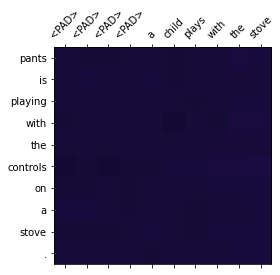

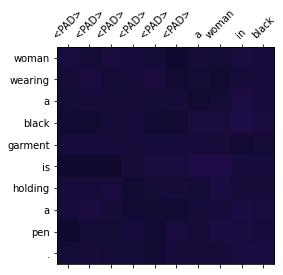

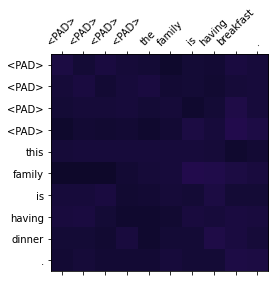

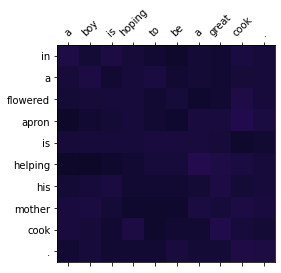

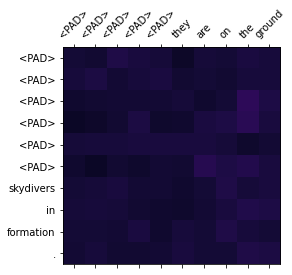

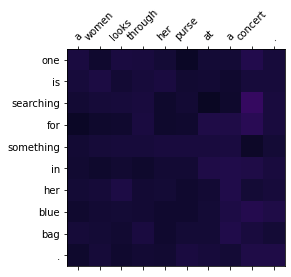

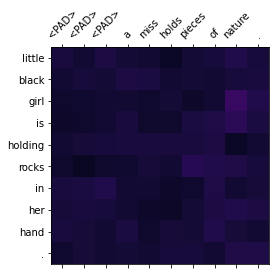

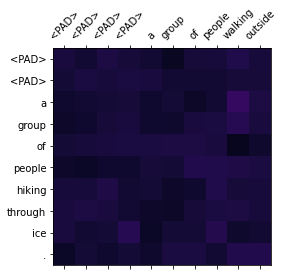

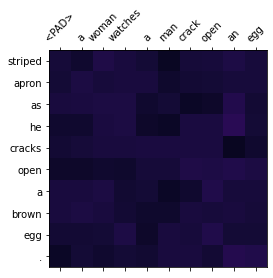

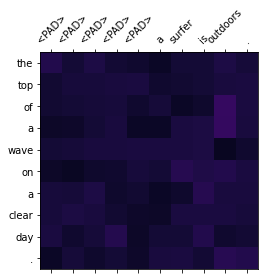

In [12]:
classifier.plot_attn(training_set[0:10])

# Atribution:
Adapted by Oier Lopez de Lacalle, Olatz Perez de Viñaspre and Ander Barrena, based on a notebook by Sam Bowman at NYU